

<img src="Movie1.jpg">
<h1 style="line-height:15px;"><center> Movie Industy and Gross Profit of a Movie </center></h1>
<h3 style="line-height:5px;"> Author:  Tianrui Guan, Xuejing Wang, Kaiyin Li </h3>
<h6 style="line-height:1px;"> Published: Dec 8, 2018 </h6>

<h2>Table of Contents</h2>

<ol style="font-size:115%;line-height:25px;">
    <li>
        <strong>Introduction</strong>
        <ul>
            <li>Background and Motivation</li>
            <li>About data</li>
            <li>Relevant information</li><br>
        </ul>
    </li>
    <li>
        <strong>Data Scraping</strong>       
    </li>
    <li>
        <strong>Data Wrangling</strong>
        <ul>
            <li>Data Cleaning and Tidying</li>
            <li>Missing data and Imputation</li>
        </ul>
    </li>
    <li>
        <strong>Data Visualization and Exploratory Data Analysis</strong>
        <ul>
            <li>Distrubution 1</li>
            <li>Distrubution 2</li>
            <li>Distrubution 3</li>
            <li> ... </li><br>
        </ul>
    </li>
    <li>
        <strong>Prediction</strong>
        <ul>
            <li>Prediction of gross profit of a movie</li>
            <li>Prediction of gross profit of a movie company</li>
            <li>Cluster 3</li>
            <li> ... </li><br>
        </ul>
    </li>
    <li>
        <strong>Conclusions</strong>
        <ul>
            <li> Summary </li>
            <li> Other Problems </li><br>
        </ul>
    </li>
    <li>
        <strong>appendix</strong>
        <ul>
            <li>Relevent resources</li>
            <li>Sources files</li><br>
        </ul>
    </li>
</ol>


## 1. Introduction
### Background and Motivations

From the exploration of data in previous projects, we realize how much we can learn from data and make conclusions from analized data. So we want to discuss something what is relavent to everyone, regardless of their interests. Entertainment is relavent to everyone's life, so we decided to explore data about it. At the same time, considering the accuracy of the data from the internet, it is hard to obtain accurate and relatively unbiased data from any websites about entertainment. After browsing many websites and sources, we targeted at Internet Movie Database ([IMDb](https://www.imdb.com/)). IMDb is an online database of information related to films, television programs, home videos and video games. According to wikipedia, IMDb has approximately 5.3 million titles (including episodes) as well as 83 million registered users before Octoer 2018. Because of the authority and completeness of IMDb, we decided to scrap data on the website, analyze the layout of the moive industry globally and try to make some prediction about an incoming movie.

### About data
The data was scrapped from [IMDb](https://www.imdb.com/). In the raw data, there are 7260 data points, including all of the movies from 1986 to 2018. Each movie has 13 attributes as following:
<ul style="line-height:25px;">
    <li>Name: name of the movie</li>
    <li>Year: year of release</li>
    <li>Released: specific date of release</li>
    <li>Genre: categories</li>
    <li>Rating: content rating(some details)<br>
         <ul>
             <li>G: General Audiences</li>
             <li>PG: Parental Guidance Suggested</li>
             <li>PG-13: Special Guidance for Children Under 13</li>
             <li>R: Accompanying of parent Under 17</li>
             <li>Others: TV-PG, TV-14, TV-MA and NC-17</li>
        </ul>
    </li>
    <li>Runtime: the length of the movie(in minutes)</li>
    <li>Score: the score of the movie, from 0 to 10</li>
    <li>Votes: the number of comments made regarding the movie</li>
    <li>Companies: list of companies involved in the production</li>
    <li>Country: the country that produced the movie</li>
    <li>Language: the language used in the movie</li>
    <li>Budget: budget of a movie</li>
    <li>Gross: the profit of a movie, which is revenue minus the cost</li>
</ul>

Due to the fact that the data is huge, we scrapped it in the script and stored it in the csv file. But we also put our scrapping code in the notebook. 

### Relevant information

The idea was inspired by a [dataset](https://www.kaggle.com/danielgrijalvas/movies) from kaggle about Movie Industry. But their data was out of date (with movies only before 2016) and some of the information was not captured (for some features like company and genre, only one of them was scrapped). Therefore, we decided to write the scrapping code and create our own dataset. We deleted and added a few columns that are relevant to our discussion, made sure that we included all informations we want, and added data from 2017 to 2018.


## 2. Data Scraping



From [IMDb](https://www.imdb.com/), we scrapped 7260 movie information. First, there are some necessary import and some helper function:

In [1]:
# import necessary code for scrapping.
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import json

In [2]:
# home page of IMDb
root = 'http://www.imdb.com'
# format of the urls we are interested, passing in different years.
url = ('http://www.imdb.com/search/title?count=220&view=simple'
    '&boxoffice_gross_us=1,&title_type=feature&release_date={year}')
# http header sent with the quests
headers = {'Accept-Language': 'en-US'}


In [3]:
# some useful functions:

# this function pass in a year as int, 
# and return a list of urls movies released in that year.
def get_movies(year):
    # request pages on that year.
    movies_html = requests.get(url.format(year=year), headers=headers).content
    # use beautiful soup to parse the page requested
    soup = BeautifulSoup(movies_html, 'html.parser')
    # find all of the links in the webpage regarding a movie
    movies = soup.findAll('a', {'href': re.compile('adv_li_i$')})
    # return a list of urls of this year.
    return [root + m['href'] for m in movies]

# pass in a full url about a movie, 
# and reutrn the content requested before parsed
def go_to_movie(url):
    movie_html = requests.get(url, headers=headers).content
    return movie_html

# pass in a full url about a production company, 
# and return the name of the company in string.
# if the page is corrupted, or the connection has timeout,
# return empty string
def get_company(url):
    # Due to internet issue, we try multiple times when we failed. 
    # (it happened and I'll have to parse the whole year again. 
    # To reduce the chances of failure, try many times before gave up)
    for i in range(5):
        # This is one of 7000 cases where the link doesn't work, 
        # so just return empty string
        if '/company/co0677497/' in url:
            return ''
        try:
            # scrap the name of the company
            html = requests.get(url, headers=headers).content
            soup = BeautifulSoup(html, 'html.parser')
            company = soup.find("meta",  property="og:title")['content'].replace('With', '(').split('(')[1].strip()
            return company
        # catch connection error, and give up after five times.
        except ConnectionError:
            continue;
    return ''

# append a list of data into the file without index
def write_csv(data):
    df = pd.DataFrame(data)
    # we stored the data in the file called movies_new.csv
    df.to_csv('movies_new.csv', mode='a', index=False)


In [4]:
# This is the page where we do most of the work for a movie.
# we pass in a beautifulsoup object regarding a movie after
# parsed by a html parser, as well as the current year we are parsing,
# in case of we can not find year information in the webpage
def scrap_details(soup, search_year):
    # first we find a tag that includes a formatted json
    details = soup.find("script", type="application/ld+json")
    js = json.loads(details.text)
    
    # access name and genre fields
    name = js['name']
    if isinstance(js['genre'], str):
        genre = js['genre']
    else:
        genre = ','.join(js['genre'])

    # The content rating of a movie,
    try:
        rating = js['contentRating']
    except KeyError:
        # if it is not given, use 'Not specified'.
        rating = 'Not specified'
        
    # find duration of the movie
    try:
        runtime = int(soup.find('h4', string='Runtime:').parent.contents[3].text[:-3].strip())
    except AttributeError:
        # if we can't, use another field and parse the string mannually
        time = re.findall(r'\d+', js['duration'])
        if len(time) > 1:
            runtime = 60 * int(time[0]) + int(time[1])
        else: 
            runtime = 60 * int(time[0])
    # find the release year and date
    try:
        year = js['datePublished'][:4]
        released = js['datePublished']
    except KeyError:
        # if it is not in the json format, use a string passed in 
        # and use 'Not specified' on the date.
        # note that sometimes the release year may differ from the year 
        # show up in the search page, so I use the year in the 
        # web search only if we can not find publish date about the movie
        year = str(search_year)
        released = 'Not specified'

    # the rating of the movie and how many comments it has
    score = float(js['aggregateRating']['ratingValue'])
    votes = int(js['aggregateRating']['ratingCount'])
    

    
    try:
        # get list of suffixes about url of a company
        companies_url = [ c['url'] for c in js['creator'] if c['@type'] == 'Organization' ]
        if companies_url:
            # if the list is not empty, then connect them with ',',
            # use get_company and store the company name (make sure to exclude empty string)
            companies = ','.join([ u for u in [ get_company(root+c_url) for c_url in companies_url ] if u != ''])
        else:
            # if it is empty, it means the creator is not specified, or all of the creation
            # and production was done by individuals
            companies = 'Personal'
    except TypeError:
        # if the result was not well-formatted (specifically, when there is only one creator,
        # the field was no longer a list, so just access the element directly.)
        if js['creator']['@type'] == 'Organization':
            companies = get_company(root+js['creator']['url'])
        else:
            companies = 'Personal'

    # locate the information about country and language in the beautifulsoup object
    country = soup.find('a', {'href': re.compile('country_of_origin')}).text
    language = ','.join(l.text for l in soup.find_all('a', {'href': re.compile('primary_language')}) )

    # find the budget field and convert it to float
    try:
        budget = soup.find('h4', string='Budget:').parent.contents[2].strip()
        if not '$' in budget:
            # in case the field was not well formatted
            budget = 'Not specified'
        else:
            budget = float(budget.replace('$','').replace(',',''))
    except AttributeError:
        # if we can not find budget information
        budget = 'Not specified'

    # find gross profit in the website, using either Cumulative Worldwide Gross
    # or Gross USA, whichever is available
    try:
        gross = soup.find('h4', string='Cumulative Worldwide Gross:').parent.contents[2].strip()[:-1]
        gross = float(gross.replace('$','').replace(',',''))
    except (AttributeError, ValueError):
        try:
            gross = soup.find('h4', string='Gross USA:').parent.contents[2].strip()[:-1]
            gross = float(gross.replace('$','').replace(',',''))
        except (AttributeError, ValueError):
            gross = 'Not specified'
    # return all of the data about the movie
    data_line = {'name': name, 'rating': rating, 'genre': genre, 'runtime': runtime, 'year': year, 
                 'released': released, 'score': score, 'votes': votes, 'rating': rating, 'companies': companies, 
                 'country': country, 'language': language, 'budget': budget, 'gross': gross}

    return data_line



In [5]:
# This is the main function in the script, to make sure it will not run,
# we left it in the main function.

def main():
    # from 1986 to 2018
    for year in range(1986, 2019):
        data = []
        # get all of the urls of movies in this year
        movies = get_movies(year)

        for movie_url in movies:
            # for each movie, I print out the informations for debuggging purpose
            print(year, '&', movie_url)
            movie_data = {}
            # get html text and use html parser to parse it
            movie_html = go_to_movie(movie_url)
            soup = BeautifulSoup(movie_html, 'html.parser')
            
            # scrap data and put it in the yearly data.
            movie_data.update(scrap_details(soup, year))
            data.append(movie_data)
        # For every year, we append all of the information once to the movie and show a prompt
        # Note that since we don't have an id for a movie, so there is not way
        # to start where we left off when the program breaks due to a bug. 
        # we can only start from scratch at different years when that happened.
        write_csv(data)
        print(year, 'done.')


Note that, even if we parsed our own data, we should not expect that our data is nice and clean. So we need to look at the data and clean it up for analysis.

## 3. Data Wrangling
### Data Cleaning and Tidying
At this step, we need to look at our data and clean it up. Import necessary tools:

In [6]:
# pandas for dataframe
import pandas as pd
# linear algebra
import numpy as np

# for data analysis
from sklearn import preprocessing
from sklearn import datasets
from scipy import stats

# for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
!pip install missingno
import missingno as msno

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


First remove some repetitive rows of features resulted from appending data each year, change string about date into datetime object and reorganize the columns. Then we check for potential duplicated movies. 

In [7]:
# read the csv file
data = pd.read_csv('./movies_new.csv')
# When appending to the file at each yaer iteration, we repetitively added
# the columns features to the data. So we need to remove those
data = data[data.name != 'name']
# replace missing data with np.nan
data.replace(['Unrated', 'Not Rated', 'Not specified'], np.nan, inplace=True)
# converting time to datetime object
data['released_date'] = pd.to_datetime(data.released)
# fixing mistake in scrapping data
p = re.compile('[A-Z],[a-z],')
old = np.unique(data[data.genre.str.match(p)]['genre'].values)
new = [n.replace(',', '') for n in old]
data['genre'].replace(old, new,inplace=True)
data = data[data.year != '2019']
# change types to int and float
data[['gross', 'budget', 'score', 'votes']] = data[['gross', 'budget', 'score', 'votes']].astype(float)


In [8]:
# check for potential duplicated elements by checking if there is movie with the same movie name and year.
# we append the string and check for duplicates
data['check'] = data.name + data.year
data[data.check.duplicated()].shape
# Since the resulting dataframe is empty, now we know that there is not duplicate rows.

(0, 15)

Then we want to tidy the data by splitting the companies, and here we got our final data. Finally we showed how many percent data were missing for each feature. 

In [9]:
# split the rows by creating a list of companies with a unique ID and merging the original dataframe on it
ll = []
for (i, l) in data[['check', 'companies']].iterrows():
    try:
        for s in (l[1].split(',')):
            ll.append([l[0], s])
    except AttributeError:
        ll.append([l[0], l[1]])
lst = pd.DataFrame(ll, columns=['check', 'company']);

# reorganize columns, taking out genre for now.
# 'genre',
order = ['name', 'year', 'released_date', 'rating', 'runtime', 'score',
         'votes', 'company', 'country', 'language', 'budget', 'gross']
data2 = pd.merge(lst, data, how='left', left_on='check', right_on='check')[order]
data2

,name,year,released_date,rating,runtime,score,votes,company,country,language,budget,gross
0,Top Gun,1986,1986-05-16,PG,110,6.9,254409.0,Paramount Pictures,USA,English,15000000.0,35683060.0
1,Top Gun,1986,1986-05-16,PG,110,6.9,254409.0,Don Simpson/Jerry Bruckheimer Films,USA,English,15000000.0,35683060.0
2,Aliens,1986,1986-07-18,R,137,8.4,582947.0,Twentieth Century Fox,USA,English,18500000.0,13106024.0
3,Aliens,1986,1986-07-18,R,137,8.4,582947.0,Brandywine Productions,USA,English,18500000.0,13106024.0
4,Aliens,1986,1986-07-18,R,137,8.4,582947.0,SLM Production Group,USA,English,18500000.0,13106024.0
5,Highlander,1986,1986-03-07,R,116,7.2,110612.0,Thorn EMI Screen Entertainment,UK,English,16000000.0,1288519.0
6,Highlander,1986,1986-03-07,R,116,7.2,110612.0,Highlander Productions Limited,UK,English,16000000.0,1288519.0
7,Highlander,1986,1986-03-07,R,116,7.2,110612.0,Davis-Panzer Productions,UK,English,16000000.0,1288519.0
8,Stand by Me,1986,1986-11-04,R,89,8.1,324695.0,Columbia Pictures Corporation,USA,English,8000000.0,5228741.0
9,Stand by Me,1986,1986-11-04,R,89,8.1,324695.0,Act III,USA,English,8000000.0,5228741.0


name             100.000000
year             100.000000
released_date     99.992915
rating            93.563129
runtime          100.000000
score            100.000000
votes            100.000000
company           99.971659
country          100.000000
language          99.982287
budget            67.206320
gross             99.649284
dtype: float64


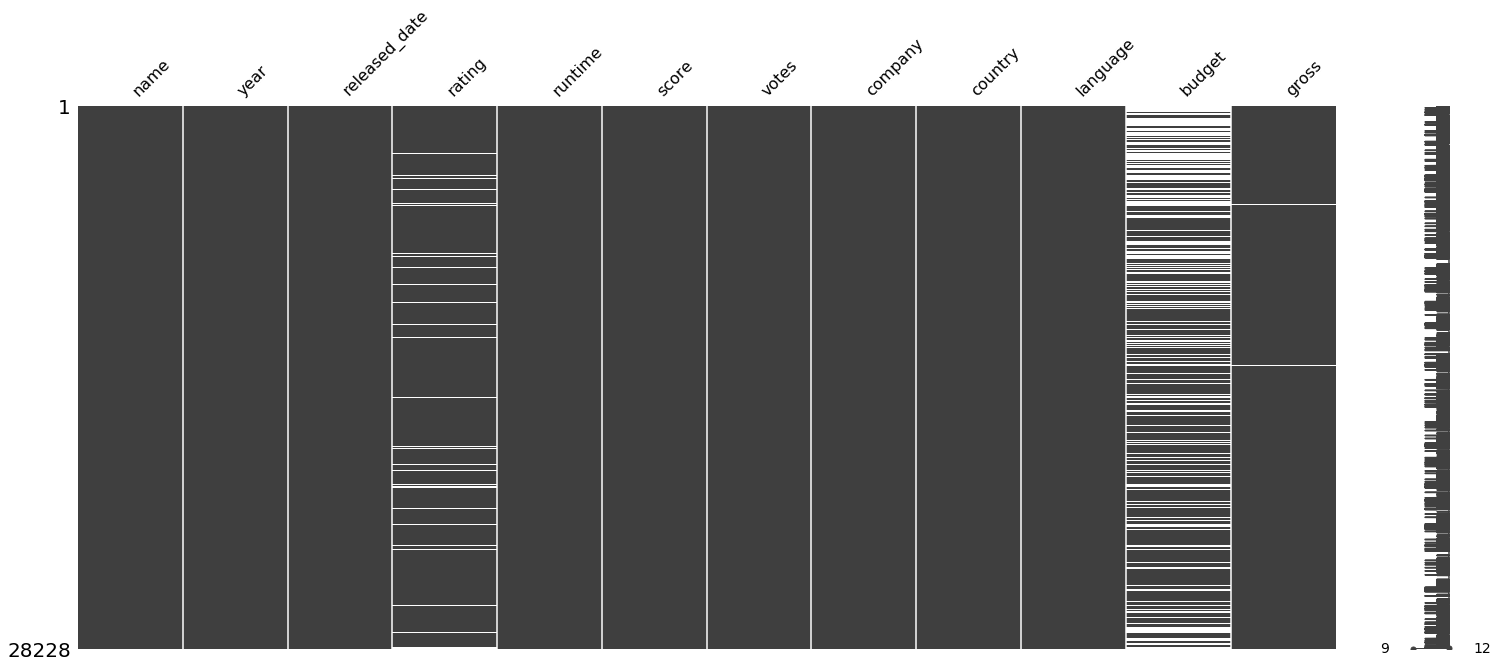

In [10]:
print(data2.notnull().sum()*100/data2.shape[0])
msno.matrix(data2)

### Missing data and Imputation

As it turn out, the data we collected is pretty good. Most of the features do not contain missing data. Around 6 percent of the movies are either not rated or missing, and features like data, companies, language and gross profit have only less than 1 percent of the missing value. However, budget has around 33 percent of missing data, which definitely need to be handled.

Now we want to try to figure out a way to impute the budget. The following is the data after we drop those rows.

name             100.00000
year             100.00000
released_date    100.00000
rating           100.00000
runtime          100.00000
score            100.00000
votes            100.00000
company          100.00000
country          100.00000
language         100.00000
budget            71.05103
gross            100.00000
dtype: float64


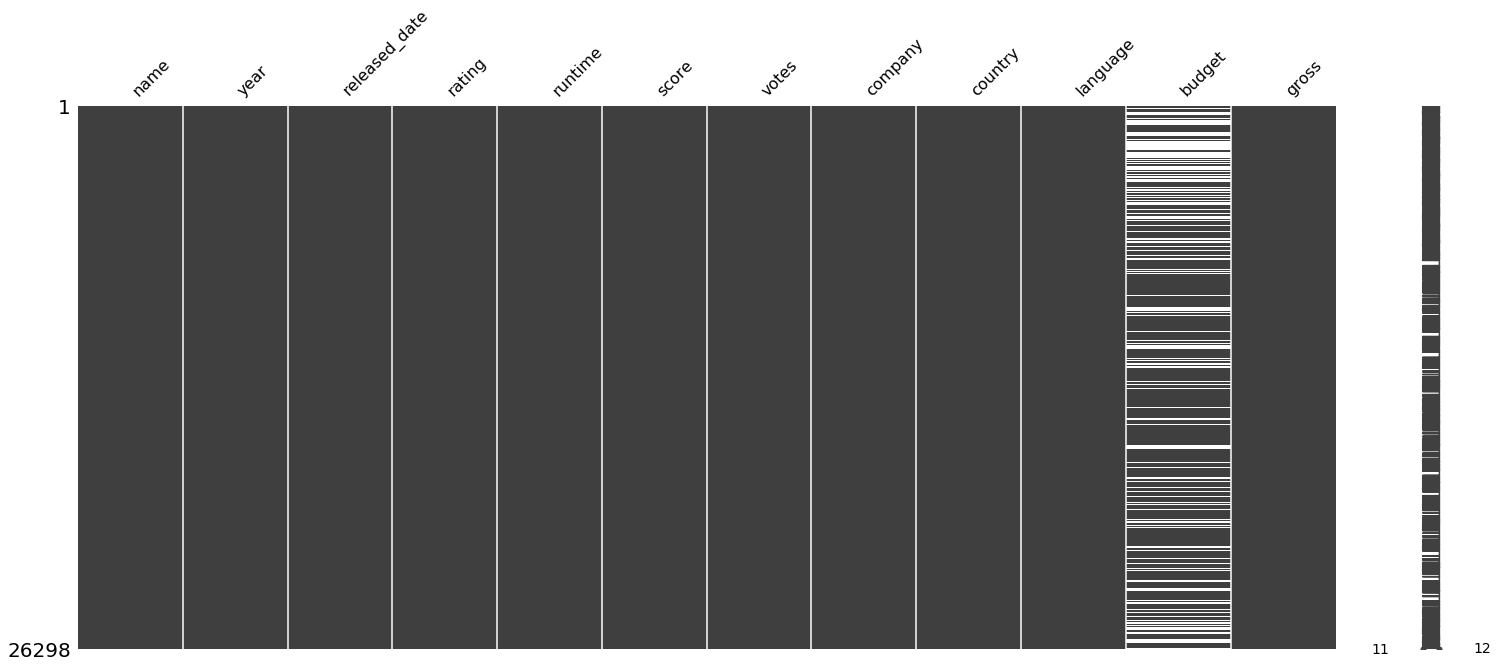

In [11]:
dataset = data2.dropna(subset=['released_date', 'rating', 'company', 'language', 'gross'])

print(dataset.notnull().sum()*100/dataset.shape[0])
msno.matrix(dataset)

Now we need to decide how to impute our budget, so we need to think of a good way of imputing the data. We decided first to see which features are correlated to budget. Then consider if the data is missing at random or not using hypothesis testing.

In [12]:
dataset

,name,year,released_date,rating,runtime,score,votes,company,country,language,budget,gross
0,Top Gun,1986,1986-05-16,PG,110,6.9,254409.0,Paramount Pictures,USA,English,15000000.0,35683060.0
1,Top Gun,1986,1986-05-16,PG,110,6.9,254409.0,Don Simpson/Jerry Bruckheimer Films,USA,English,15000000.0,35683060.0
2,Aliens,1986,1986-07-18,R,137,8.4,582947.0,Twentieth Century Fox,USA,English,18500000.0,13106024.0
3,Aliens,1986,1986-07-18,R,137,8.4,582947.0,Brandywine Productions,USA,English,18500000.0,13106024.0
4,Aliens,1986,1986-07-18,R,137,8.4,582947.0,SLM Production Group,USA,English,18500000.0,13106024.0
5,Highlander,1986,1986-03-07,R,116,7.2,110612.0,Thorn EMI Screen Entertainment,UK,English,16000000.0,1288519.0
6,Highlander,1986,1986-03-07,R,116,7.2,110612.0,Highlander Productions Limited,UK,English,16000000.0,1288519.0
7,Highlander,1986,1986-03-07,R,116,7.2,110612.0,Davis-Panzer Productions,UK,English,16000000.0,1288519.0
8,Stand by Me,1986,1986-11-04,R,89,8.1,324695.0,Columbia Pictures Corporation,USA,English,8000000.0,5228741.0
9,Stand by Me,1986,1986-11-04,R,89,8.1,324695.0,Act III,USA,English,8000000.0,5228741.0


## 4. Data Visualization and Exploratory Data Analysis
Now we want to see which factor could potentially affect gross profit
### grouped by company


In [13]:
# by country, company, year
from statsmodels.formula.api import ols

sns.set(style="darkgrid")


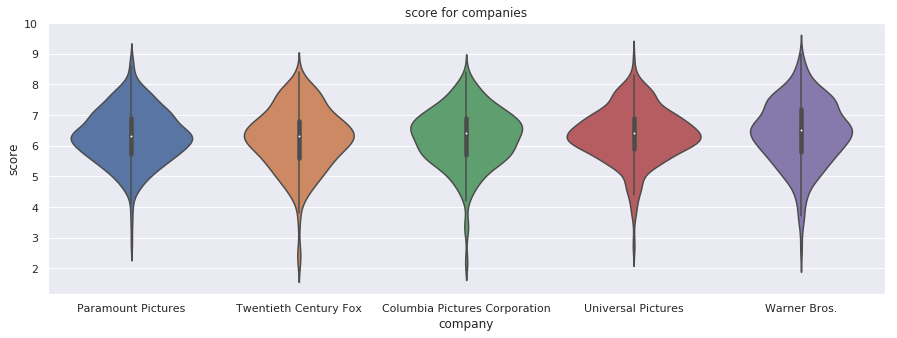

In [14]:


company_data = dataset[['company', 'score']].groupby(['company']).count()
company_data = company_data.sort_values(by='score', ascending=False)
set1 = dataset[dataset.company.isin(company_data.index[:5])]


plot1 = sns.violinplot(x = 'company', y = 'score', data = set1).set_title("score for companies")
plot1.figure.set_size_inches(15, 5);




# company_data

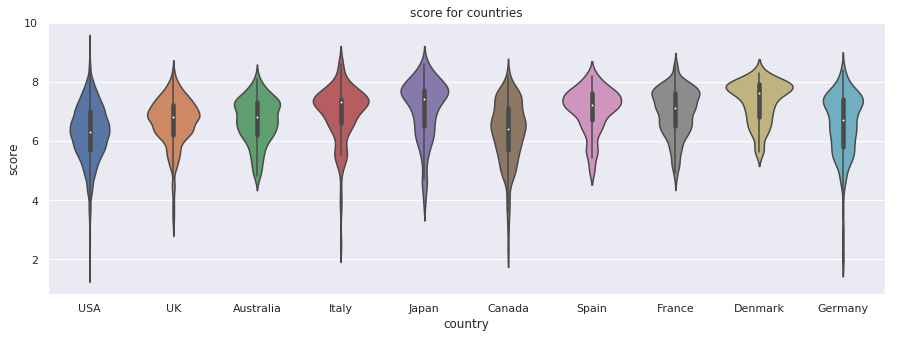

In [15]:
country_data = dataset[['country', 'score']].groupby(['country']).count()
country_data = country_data.sort_values(by='score', ascending=False)[:10]
set3 = dataset[dataset.country.isin(country_data.index)]


plot3 = sns.violinplot(x = 'country', y = 'score', data = set3).set_title("score for countries")
plot3.figure.set_size_inches(15, 5);


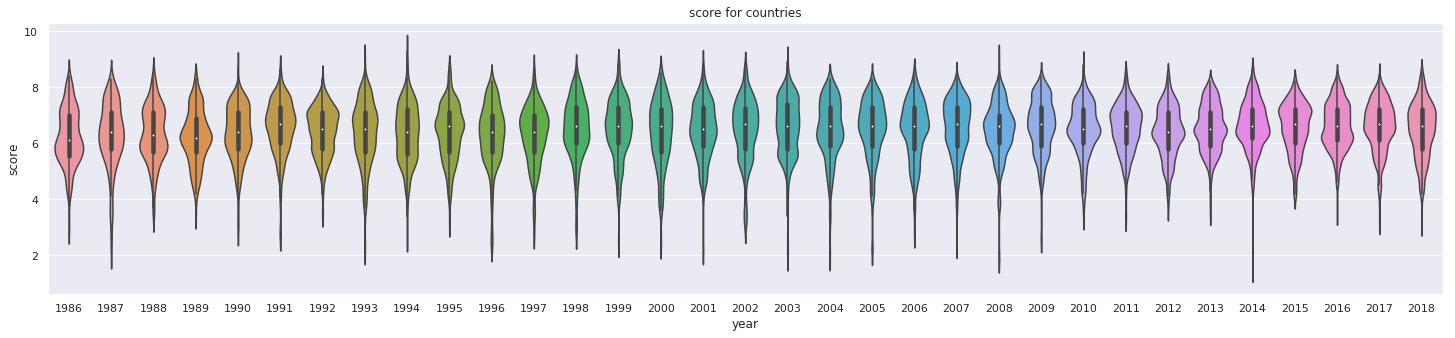

In [16]:
year_data = dataset[['year', 'score']].groupby(['year']).count()
# year_data = year_data.sort_values(by='score', ascending=False)[:15]
set3 = dataset[dataset.year.isin(year_data.index)]


plot3 = sns.violinplot(x = 'year', y = 'score', data = set3).set_title("score for countries")
plot3.figure.set_size_inches(25, 5);


slope: 8694987.59651
intercept: -29374363.7209
r-value: 0.0909348404748
p_value: 2.07642625768e-49
std_err: 587206.324686
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     219.3
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           2.08e-49
Time:                        03:17:52   Log-Likelihood:                -36754.
No. Observations:               26298   AIC:                         7.351e+04
Df Residuals:                   26296   BIC:                         7.353e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------

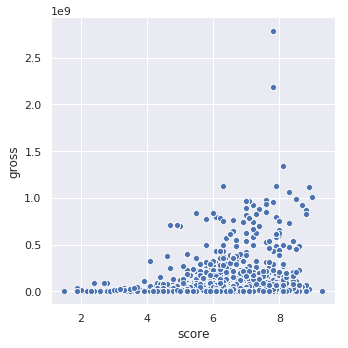

In [17]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dataset.score, dataset.gross)
print("slope:", slope)
print("intercept:", intercept)
print("r-value:", r_value)
print("p_value:", p_value)
print("std_err:", std_err)

model1 = ols(formula='score ~ gross', data=dataset).fit()  
print(model1.summary())

plot1 = sns.relplot(x = "score", y = "gross", data = dataset)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


slope: 2.11447400803
intercept: -8009270.21566
r-value: 0.674355772352
p_value: 0.0
std_err: 0.0169389126615
                            OLS Regression Results                            
Dep. Variable:                 budget   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.558e+04
Date:                Sun, 09 Dec 2018   Prob (F-statistic):               0.00
Time:                        03:22:19   Log-Likelihood:            -3.4917e+05
No. Observations:               18685   AIC:                         6.983e+05
Df Residuals:                   18683   BIC:                         6.984e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

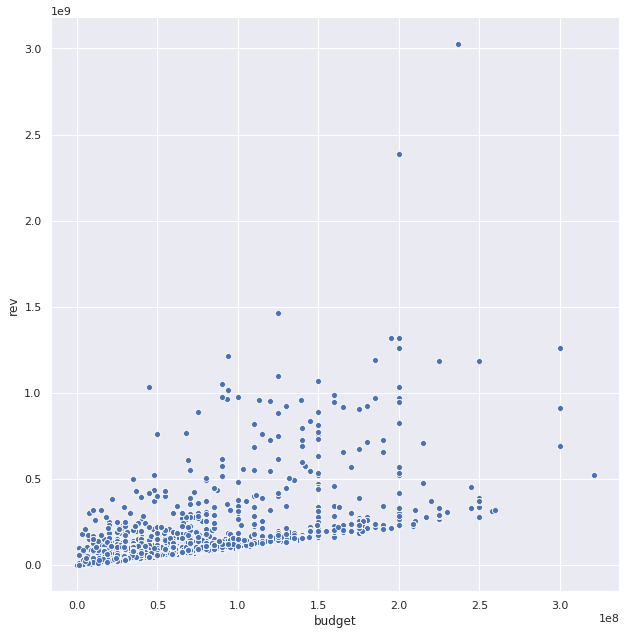

In [26]:
datas = dataset.dropna(subset=['budget'])
datas['rev'] = datas.budget + datas.gross
slope, intercept, r_value, p_value, std_err = stats.linregress(datas.budget, datas.rev)
print("slope:", slope)
print("intercept:", intercept)
print("r-value:", r_value)
print("p_value:", p_value)
print("std_err:", std_err)

model1 = ols(formula='budget ~ rev', data=datas).fit()  
print(model1.summary())

plot1 = sns.relplot(x = "budget", y = "rev", data = datas)
plot1.fig.set_size_inches(10, 10)



In [ ]:
data.shape

data = data[data.name.duplicated()]
data[data.year.duplicated()].shape
data
# note that: see companies: Personal & Not specified.
# temp = [d for d in data.released if '-' not in d]
# temp
# data.set_index('name')
# data[data.duplicated()]

# data.drop_duplicates(subset='released')